# Phân Tích Dữ Liệu Khách Hàng Dựa Trên Mô Hình RFM

Mô hình RFM (Recency, Frequency, Monetary) là một trong những phương pháp phổ biến để phân đoạn khách hàng dựa trên hành vi mua hàng. Trong dự án này, chúng ta sẽ sử dụng mô hình RFM để phân tích và phân cụm dữ liệu khách hàng từ tệp `data.csv`. Các thư viện cần thiết sẽ được nhập vào trước khi bắt đầu phân tích.


In [8]:
import pandas as pd

# Load dữ liệu
file_path = 'data.csv'
data = pd.read_csv(file_path)

# Hiển thị một vài thông tin cơ bản về dữ liệu
print(data.head())
print(data.info())

# Chọn các cột RFM để chuẩn bị cho phân cụm
rfm_data = data[['recency', 'frequency', 'monetary']]


                     user_pseudo_id  recency  frequency  monetary
0  e4dfe4fb9651706c9f4d269e1e565044      256          1         0
1  d1f4569625eab3b249c3cd200d1c4fd6      512          1         0
2  1bc15184753def3334b67f8045cbb1fb      512          1         0
3  b18d3f1e73bea0ec88ff447fa5193a11      512          1         0
4  d1e3bcced12dfde70031d643fc191da2      512          1         0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   user_pseudo_id  25000 non-null  object
 1   recency         25000 non-null  int64 
 2   frequency       25000 non-null  int64 
 3   monetary        25000 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 781.4+ KB
None


## Thông Tin Cơ Bản Về Dữ Liệu

Trước khi bắt đầu quá trình phân tích, chúng ta sẽ hiển thị một vài thông tin cơ bản về dữ liệu như một số dòng đầu tiên và mô tả tổng quan về các cột để hiểu rõ hơn về dữ liệu đầu vào.


In [9]:
from sklearn.preprocessing import StandardScaler

# Chuẩn hóa dữ liệu RFM
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm_data)

# Kiểm tra dữ liệu đã chuẩn hóa
print(pd.DataFrame(rfm_scaled, columns=['recency', 'frequency', 'monetary']).head())


    recency  frequency  monetary
0 -0.624943  -0.600268  -0.11433
1  0.540118  -0.600268  -0.11433
2  0.540118  -0.600268  -0.11433
3  0.540118  -0.600268  -0.11433
4  0.540118  -0.600268  -0.11433


## Chuẩn Bị Dữ Liệu RFM Cho Phân Cụm

Chúng ta sẽ lựa chọn các cột liên quan đến RFM (Recency, Frequency, Monetary) từ dữ liệu ban đầu. Sau đó, sử dụng phương pháp chuẩn hóa để đưa các giá trị RFM về cùng một đơn vị đo lường, giúp quá trình hiệu quả hơn.


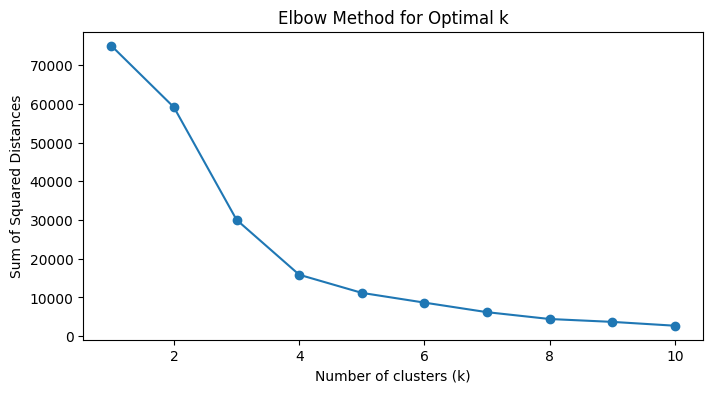

In [10]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Tìm số lượng cụm tối ưu bằng phương pháp Elbow
sse = []
k_range = range(1, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(rfm_scaled)
    sse.append(kmeans.inertia_)

# Vẽ biểu đồ Elbow
plt.figure(figsize=(8, 4))
plt.plot(k_range, sse, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Sum of Squared Distances')
plt.title('Elbow Method for Optimal k')
plt.show()


In [37]:
from sklearn.cluster import KMeans

# Chọn k = 4 (sau khi phân tích phương pháp Elbow) và thực hiện phân cụm
k = 4
kmeans = KMeans(n_clusters=k, random_state=42)
data['cluster'] = kmeans.fit_predict(rfm_scaled)

# Kiểm tra số lượng khách hàng trong mỗi cụm
print(data['cluster'].value_counts())

# Tính các giá trị trung bình của R, F, M trong mỗi cụm để hỗ trợ việc gán nhãn
cluster_analysis = data.groupby('cluster')[['recency', 'frequency', 'monetary']].mean()
print(cluster_analysis)


cluster
0    9723
2    8653
1    6334
3     290
Name: count, dtype: int64
            recency  frequency    monetary
cluster                                   
0        208.723645   1.000000    0.007199
1        335.083675   2.000000    2.164509
2        648.491853   1.000000    0.000000
3        240.496552   1.993103  132.551724


In [43]:
# Cập nhật gán nhãn khách hàng dựa trên tiêu chí chính xác hơn
# Khách hàng VIP: R thấp, F cao, M cao
# Khách hàng Thường xuyên: R trung bình, F trung bình, M trung bình
# Khách hàng Tiềm năng: R cao, F thấp, M trung bình hoặc cao
# Khách hàng Không hoạt động: R rất cao, F rất thấp, M rất thấp

# Phân tích cluster_analysis để gán nhãn chính xác
cluster_labels = {
    0: 'Khách hàng Tiềm năng',  # Ví dụ: Cụm này có thể có R rất cao, F rất thấp, M rất thấp
    1: 'Khách hàng Thường xuyên',  # Ví dụ: Cụm này có thể có R rất thấp, F cao, M cao
    2: 'Khách hàng Không hoạt động',  # Ví dụ: Cụm này có thể có R cao, F thấp, M trung bình hoặc cao
    3: 'Khách hàng VIP'  # Ví dụ: Cụm này có thể có R trung bình, F trung bình, M trung bình
}

# Áp dụng gán nhãn cho các cụm dựa trên phân tích trên
data['segment'] = data['cluster'].map(cluster_labels)

# Hiển thị kết quả phân cụm với nhãn khách hàng mới
print(data[['user_pseudo_id', 'recency', 'frequency', 'monetary', 'segment']].head())


                     user_pseudo_id  recency  frequency  monetary  \
0  e4dfe4fb9651706c9f4d269e1e565044      256          1         0   
1  d1f4569625eab3b249c3cd200d1c4fd6      512          1         0   
2  1bc15184753def3334b67f8045cbb1fb      512          1         0   
3  b18d3f1e73bea0ec88ff447fa5193a11      512          1         0   
4  d1e3bcced12dfde70031d643fc191da2      512          1         0   

                      segment  
0        Khách hàng Tiềm năng  
1  Khách hàng Không hoạt động  
2  Khách hàng Không hoạt động  
3  Khách hàng Không hoạt động  
4  Khách hàng Không hoạt động  


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_19540\617956392.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=segment_counts.index, y=segment_counts.values, palette='viridis')


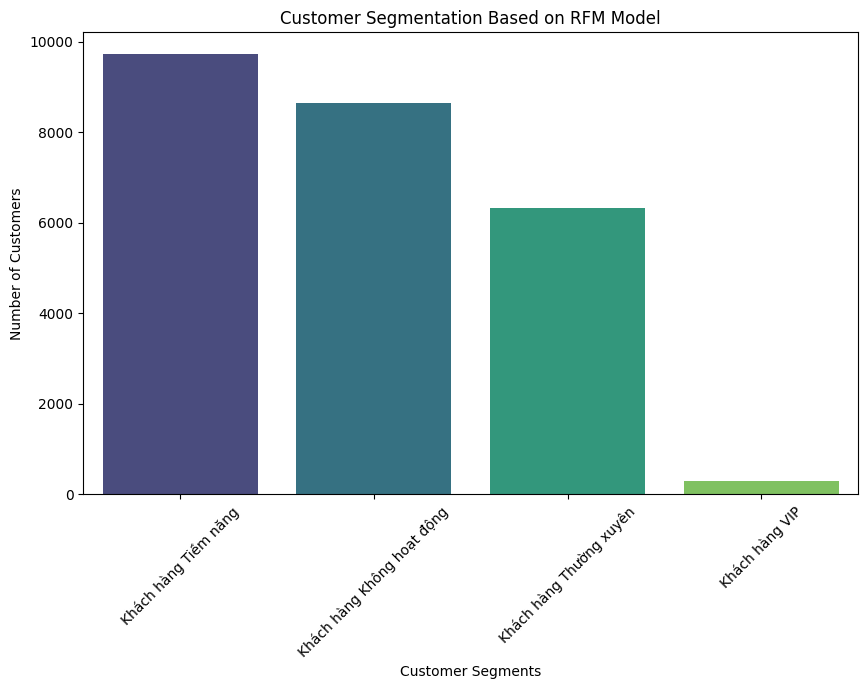

In [44]:
import matplotlib.pyplot as plt
import seaborn as sns

# Đếm số lượng khách hàng trong từng phân đoạn
segment_counts = data['segment'].value_counts()

# Tạo biểu đồ cho các phân đoạn khách hàng
plt.figure(figsize=(10, 6))
sns.barplot(x=segment_counts.index, y=segment_counts.values, palette='viridis')

# Thêm nhãn và tiêu đề
plt.xlabel('Customer Segments')
plt.ylabel('Number of Customers')
plt.title('Customer Segmentation Based on RFM Model')
plt.xticks(rotation=45)
plt.show()


In [45]:
# Kiểm tra chi tiết về các giá trị RFM trong mỗi phân đoạn
for segment, subset in data.groupby('segment'):
    print(f"Segment: {segment}")
    print(subset[['recency', 'frequency', 'monetary']].describe())
    print("\n")


Segment: Khách hàng Không hoạt động
           recency  frequency  monetary
count  8653.000000     8653.0    8653.0
mean    648.491853        1.0       0.0
std      87.814933        0.0       0.0
min     429.000000        1.0       0.0
25%     583.000000        1.0       0.0
50%     691.000000        1.0       0.0
75%     722.000000        1.0       0.0
max     738.000000        1.0       0.0


Segment: Khách hàng Thường xuyên
           recency  frequency     monetary
count  6334.000000     6334.0  6334.000000
mean    335.083675        2.0     2.164509
std     158.672818        0.0     9.292215
min      28.000000        2.0     0.000000
25%     269.000000        2.0     0.000000
50%     291.000000        2.0     0.000000
75%     524.000000        2.0     0.000000
max     563.000000        2.0    60.000000


Segment: Khách hàng Tiềm năng
           recency  frequency     monetary
count  9723.000000     9723.0  9723.000000
mean    208.723645        1.0     0.007199
std      75.414170   